<h1>Практическая работа №6 и Лабораторная работа №4<h1>
<h2>Выполнил: Тимофеев Илья<h2>
<h2>Группа: ББМО-01-22<h2/>

 **Шаг 1**
Выполним импорт необходимых библиотек.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets

**Шаг 2**
Загрузим набор данных (MNIST), разобьем данные на подвыборки.


In [2]:
transform = transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)
print("Training data:",len(train_loader),"Validation data:",len(val_loader),"Test data:",len(test_loader))

100%|██████████| 9912422/9912422 [00:00<00:00, 118647742.08it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 47993539.55it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 48709291.93it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17429578.01it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Training data: 50000 Validation data: 10000 Test data: 10000


**Шаг 3**
Настроим использование графического ускорителя.

In [3]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

**Шаг 4. Создание атак на модель НС.**
Создадим класс НС на основе фреймворка torch.

In [4]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

**Шаг 5. Создание атак на модель НС.**
Проверим работоспособность созданного класса НС.

In [5]:
model = Net().to(device)

**Шаг 6. Создание атак на модель НС.**
Создадим оптимизатор, функцию потерь и трейнер сети.

In [6]:
optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

**Шаг 7. Создание атак на модель НС.**
Определим функцию обучения сети.


In [7]:
def fit(model,device,train_loader,val_loader,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label = data[0].to(device),data[1].to(device)
        output = model(input)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

**Шаг 8. Создание атак на модель НС.**
Обучим модель.

In [8]:
loss, val_loss = fit(model, device, train_loader, val_loader, 10)

Fitting the model...


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1 Loss: 0.27364798618042624 Val_Loss: 0.1514760968370528
Epoch: 2 Loss: 0.1085534713517188 Val_Loss: 0.10566764865441187
Epoch: 3 Loss: 0.08270403996756964 Val_Loss: 0.09490188534468656
Epoch: 4 Loss: 0.07184107978025048 Val_Loss: 0.08452242758264042
Epoch: 5 Loss: 0.06318974395321775 Val_Loss: 0.08870745507981724
Epoch: 6 Loss: 0.06183685142550104 Val_Loss: 0.08463778928197853
Epoch: 7 Loss: 0.05919382139317826 Val_Loss: 0.09058659238292247
Epoch: 8 Loss: 0.05746152144902565 Val_Loss: 0.0884336885243108
Epoch: 9 Loss: 0.04317616631293602 Val_Loss: 0.07717185551352328
Epoch: 10 Loss: 0.04143624664735127 Val_Loss: 0.08422930549846026


**Шаг 9. Создание атак на модель НС.**
Построим графики потерь при обучении и валидации в зависимости от эпохи.


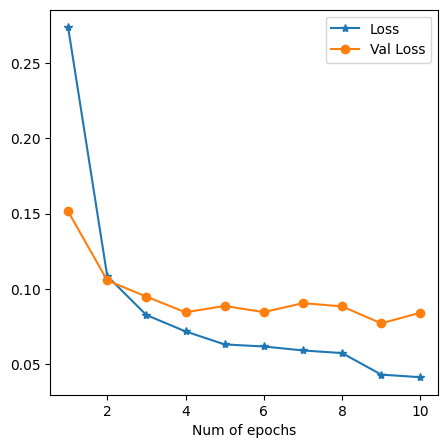

In [9]:
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,11), loss, "*-",label="Loss")
plt.plot(np.arange(1,11), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()

**Шаг 10. Создание атак на модель НС.**
Создадим функции атак FGSM, I-FGSM, MI-FGSM.

In [10]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

In [11]:
def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

In [12]:
def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

**Шаг 11. Создание атак на модель НС.**
Создадим функцию проверки.

In [13]:
def test(model,device,test_loader,epsilon,attack):
  correct = 0
  adv_examples = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != target.item():
      continue
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)
    elif attack == "ifgsm":
      perturbed_data = ifgsm_attack(data,epsilon,data_grad)
    elif attack == "mifgsm":
      perturbed_data = mifgsm_attack(data,epsilon,data_grad)
    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
      correct += 1
    if (epsilon == 0) and (len(adv_examples) < 5):
      adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
      adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    else:
      if len(adv_examples) < 5:
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
  return final_acc, adv_examples

**Шаг 12. Создание атак на модель НС.**
Построим графики успешности атак(Accuracy/эпсилон) и примеры выполненных атак в зависимости от степени возмущения epsilon:

Epsilon: 0	Test Accuracy = 9761 / 10000 = 0.9761
Epsilon: 0.007	Test Accuracy = 9721 / 10000 = 0.9721
Epsilon: 0.01	Test Accuracy = 9730 / 10000 = 0.973
Epsilon: 0.02	Test Accuracy = 9665 / 10000 = 0.9665
Epsilon: 0.03	Test Accuracy = 9624 / 10000 = 0.9624
Epsilon: 0.05	Test Accuracy = 9423 / 10000 = 0.9423
Epsilon: 0.1	Test Accuracy = 8680 / 10000 = 0.868
Epsilon: 0.2	Test Accuracy = 5786 / 10000 = 0.5786
Epsilon: 0.3	Test Accuracy = 2929 / 10000 = 0.2929


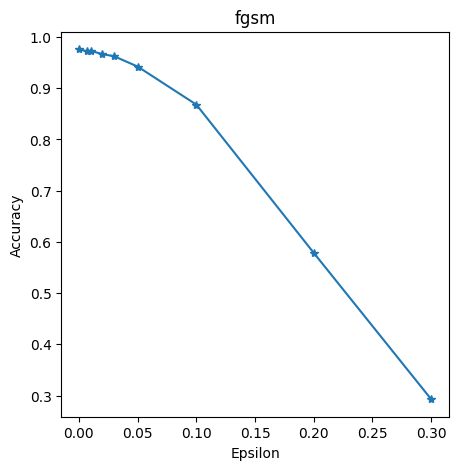

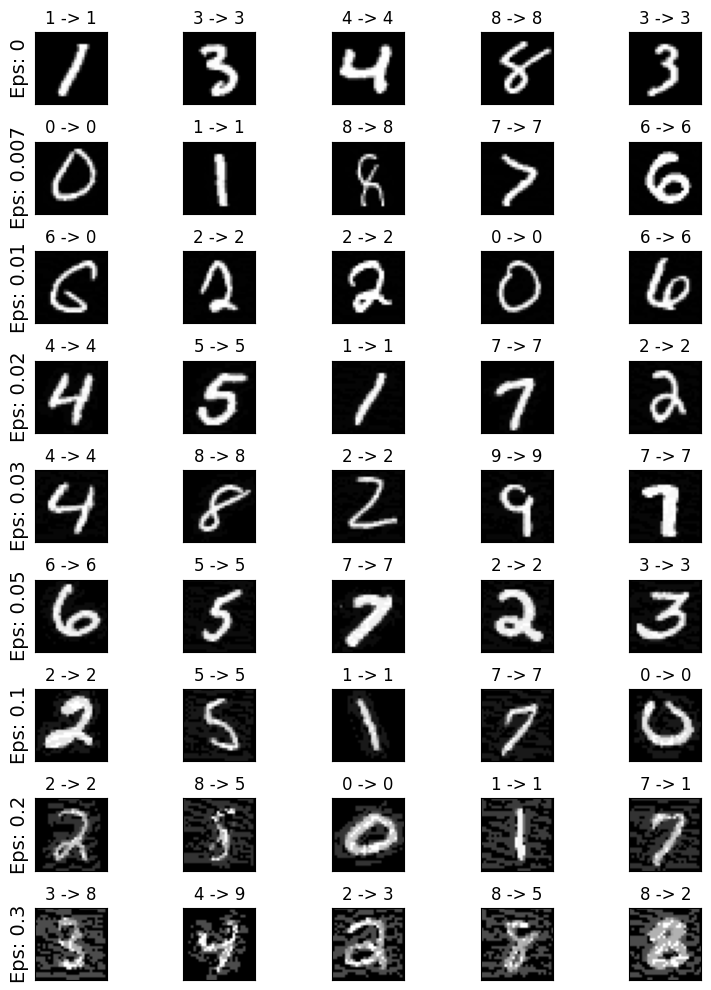

Epsilon: 0	Test Accuracy = 9780 / 10000 = 0.978
Epsilon: 0.007	Test Accuracy = 9722 / 10000 = 0.9722
Epsilon: 0.01	Test Accuracy = 9725 / 10000 = 0.9725
Epsilon: 0.02	Test Accuracy = 9687 / 10000 = 0.9687
Epsilon: 0.03	Test Accuracy = 9660 / 10000 = 0.966
Epsilon: 0.05	Test Accuracy = 9510 / 10000 = 0.951
Epsilon: 0.1	Test Accuracy = 8931 / 10000 = 0.8931
Epsilon: 0.2	Test Accuracy = 6417 / 10000 = 0.6417
Epsilon: 0.3	Test Accuracy = 3627 / 10000 = 0.3627


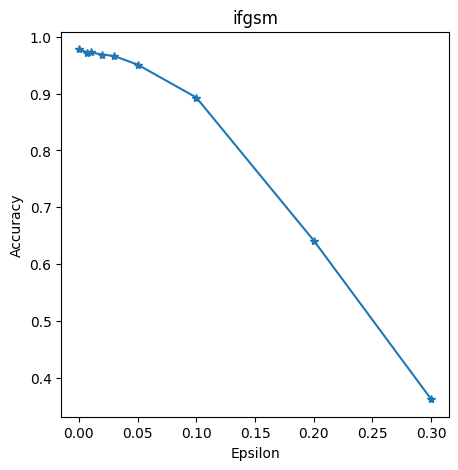

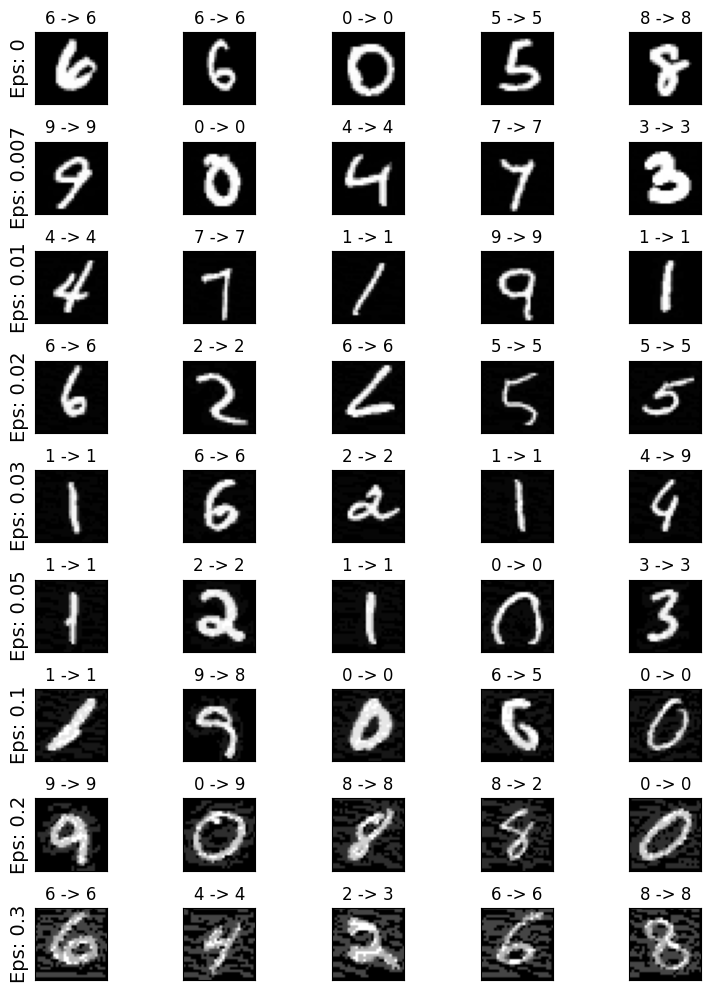

Epsilon: 0	Test Accuracy = 9766 / 10000 = 0.9766
Epsilon: 0.007	Test Accuracy = 9738 / 10000 = 0.9738
Epsilon: 0.01	Test Accuracy = 9736 / 10000 = 0.9736
Epsilon: 0.02	Test Accuracy = 9659 / 10000 = 0.9659
Epsilon: 0.03	Test Accuracy = 9654 / 10000 = 0.9654
Epsilon: 0.05	Test Accuracy = 9511 / 10000 = 0.9511
Epsilon: 0.1	Test Accuracy = 8902 / 10000 = 0.8902
Epsilon: 0.2	Test Accuracy = 6424 / 10000 = 0.6424
Epsilon: 0.3	Test Accuracy = 3602 / 10000 = 0.3602


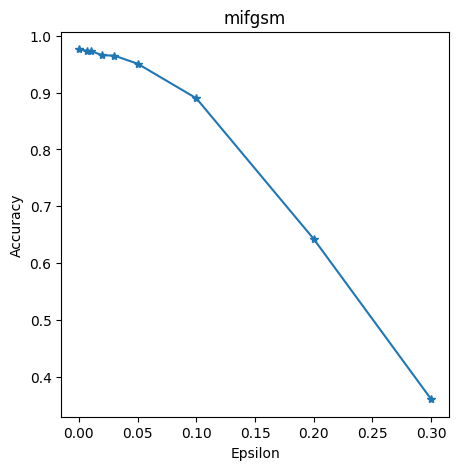

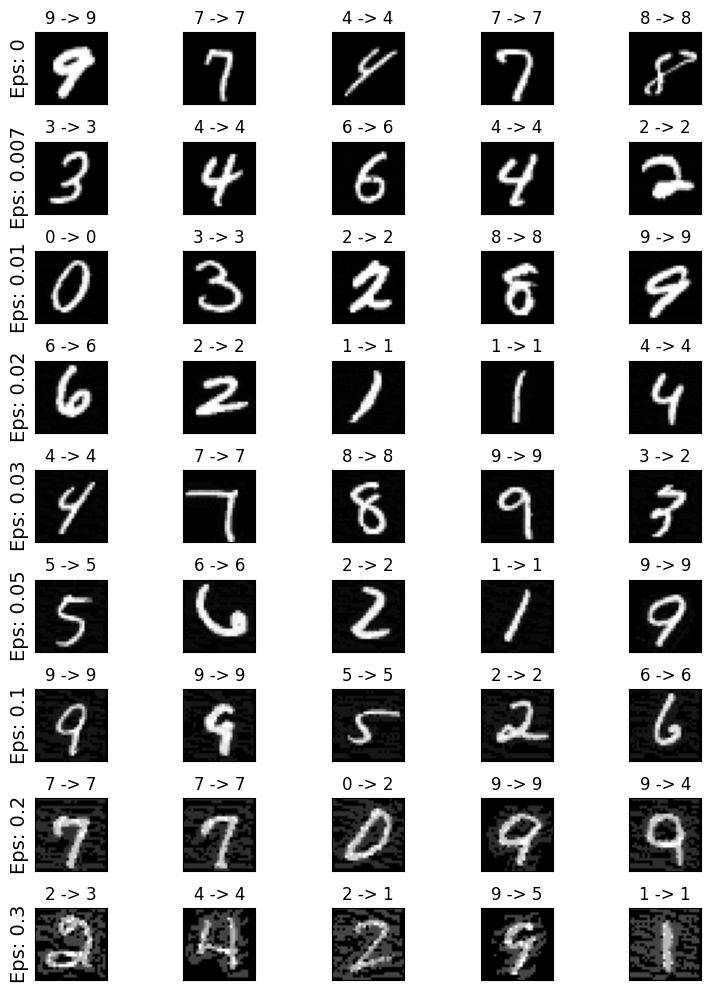

In [14]:
epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
for attack in ("fgsm","ifgsm","mifgsm"):
  accuracies = []
  examples = []
  for eps in epsilons:
    acc, ex = test(model, device,test_loader,eps,attack)
    accuracies.append(acc)
    examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()
  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
    for j in range(len(examples[i])):
      cnt += 1
      plt.subplot(len(epsilons),len(examples[0]),cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      if j == 0:
        plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
      orig,adv,ex = examples[i][j]
      plt.title("{} -> {}".format(orig, adv))
      plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

**Шаг 13. Защита от атак.**
Создадим 2 класса НС.

In [15]:
class NetF(nn.Module):
  def __init__(self):
    super(NetF, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

In [16]:
class NetF1(nn.Module):
  def __init__(self):
    super(NetF1, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(4608, 64)
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

**Шаг 14. Защита от атак.**
Переопределим функцию обучения и тестирования.

In [17]:
def fit(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label = data[0].to(device),data[1].to(device)
        output = model(input)
        output = F.log_softmax(output/Temp,dim=1)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
      else:
        val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

  def test(model,device,test_loader,epsilon,Temp,attack):
    correct=0
    adv_examples = []
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      data.requires_grad = True
      output = model(data)
      output = F.log_softmax(output/Temp,dim=1)
      init_pred = output.max(1, keepdim=True)[1]
      if init_pred.item() != target.item():
        continue
      loss = F.nll_loss(output, target)
      model.zero_grad()
      loss.backward()
      data_grad = data.grad.data
      if attack == "fgsm":
        perturbed_data = fgsm_attack(data,epsilon,data_grad)
      elif attack == "ifgsm":
        perturbed_data = ifgsm_attack(data,epsilon,data_grad)
      elif attack == "mifgsm":
        perturbed_data = mifgsm_attack(data,epsilon,data_grad)
      output = model(perturbed_data)
      final_pred = output.max(1, keepdim=True)[1]
      if final_pred.item() == target.item():
        correct += 1
        if (epsilon == 0) and (len(adv_examples) < 5):
          adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
          adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
          if len(adv_examples) < 5:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
  return final_acc,adv_examples

**Шаг 15. Защита от атак.**
Создадим функцию защиты методом дистилляции.

In [18]:
def defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons):
  modelF = NetF().to(device)
  optimizerF = optim.Adam(modelF.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)
  modelF1 = NetF1().to(device)
  optimizerF1 = optim.Adam(modelF1.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)
  criterion = nn.NLLLoss()
  lossF,val_lossF=fit(modelF,device,optimizerF,schedulerF,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF,"o-",label="Val Loss")
  plt.title("Network F")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()
  #converting target labels to soft labels
  for data in train_loader:
    input, label = data[0].to(device),data[1].to(device)
    softlabel = F.log_softmax(modelF(input),dim=1)
    data[1] = softlabel
  lossF1,val_lossF1=fit(modelF1,device,optimizerF1,schedulerF1,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF1, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF1,"o-",label="Val Loss")
  plt.title("Network F'")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()
  model = NetF1().to(device)
  model.load_state_dict(modelF1.state_dict())
  for attack in ("fgsm","ifgsm","mifgsm"):
    accuracies = []
    examples = []
    for eps in epsilons:
      acc, ex = test(model,device,test_loader,eps,"fgsm")
      accuracies.append(acc)
      examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()
  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
    for j in range(len(examples[i])):
      cnt += 1
      plt.subplot(len(epsilons),len(examples[0]),cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      if j == 0:
        plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
      orig,adv,ex = examples[i][j]
      plt.title("{} -> {}".format(orig, adv))
      plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

**Шаг 16. Защита от атак.**
Получим результаты оценки защищенных сетей.

Fitting the model...
Epoch: 1 Loss: 0.5586636638233529 Val_Loss: 0.00013734494727104903
Epoch: 2 Loss: 0.32000435114445375 Val_Loss: 3.885443676263094e-05
Epoch: 3 Loss: 0.22065452498864171 Val_Loss: 2.6573986560106278e-05
Epoch: 4 Loss: 0.166122699417228 Val_Loss: 2.089180740586016e-06
Epoch: 5 Loss: 0.13697167539701155 Val_Loss: 2.0265563023258437e-10
Epoch: 6 Loss: 0.12113108773361844 Val_Loss: 1.0716508119367063e-05
Epoch: 7 Loss: 0.11046593322182684 Val_Loss: 1.7166009683933225e-09
Epoch: 8 Loss: 0.10070784397399411 Val_Loss: 1.8325391924008726e-06
Epoch: 9 Loss: 0.09728810295630186 Val_Loss: 6.29195295914542e-06
Epoch: 10 Loss: 0.08716456005690097 Val_Loss: 1.969227523659356e-08


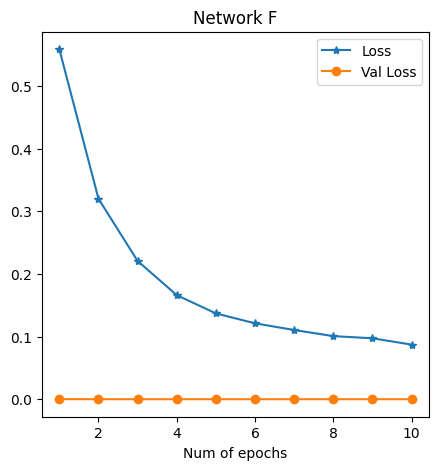

Fitting the model...
Epoch: 1 Loss: 0.6708522244577682 Val_Loss: 8.905845731496811e-05
Epoch: 2 Loss: 0.4460383526137011 Val_Loss: 8.857200965285301e-05
Epoch: 3 Loss: 0.38187247984231215 Val_Loss: 2.3023875430226327e-06
Epoch: 4 Loss: 0.33720084358059105 Val_Loss: 2.4729261049287745e-06
Epoch: 5 Loss: 0.29825992335180374 Val_Loss: 1.5593550726771354e-05
Epoch: 6 Loss: 0.2625956706629719 Val_Loss: 2.759788396360818e-07
Epoch: 7 Loss: 0.23289492150114827 Val_Loss: 3.2116492511704563e-07
Epoch: 8 Loss: 0.20901024173459745 Val_Loss: 1.4200437907129527e-05
Epoch: 9 Loss: 0.18101272500992469 Val_Loss: 0.0003574684738783617
Epoch: 10 Loss: 0.17011370223791447 Val_Loss: 7.655074005015194e-08


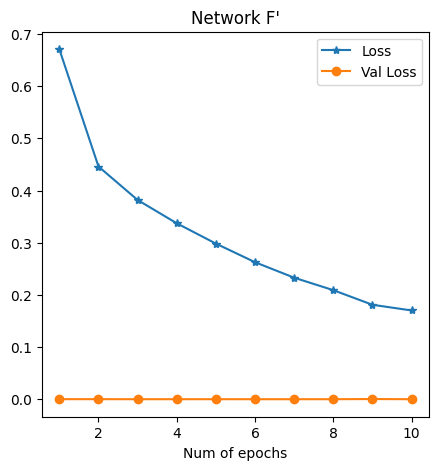

Epsilon: 0	Test Accuracy = 9282 / 10000 = 0.9282
Epsilon: 0.007	Test Accuracy = 9266 / 10000 = 0.9266
Epsilon: 0.01	Test Accuracy = 9253 / 10000 = 0.9253
Epsilon: 0.02	Test Accuracy = 9186 / 10000 = 0.9186
Epsilon: 0.03	Test Accuracy = 9065 / 10000 = 0.9065
Epsilon: 0.05	Test Accuracy = 8850 / 10000 = 0.885
Epsilon: 0.1	Test Accuracy = 7835 / 10000 = 0.7835
Epsilon: 0.2	Test Accuracy = 4814 / 10000 = 0.4814
Epsilon: 0.3	Test Accuracy = 2124 / 10000 = 0.2124
Epsilon: 0	Test Accuracy = 9285 / 10000 = 0.9285
Epsilon: 0.007	Test Accuracy = 9264 / 10000 = 0.9264
Epsilon: 0.01	Test Accuracy = 9239 / 10000 = 0.9239
Epsilon: 0.02	Test Accuracy = 9177 / 10000 = 0.9177
Epsilon: 0.03	Test Accuracy = 9107 / 10000 = 0.9107
Epsilon: 0.05	Test Accuracy = 8819 / 10000 = 0.8819
Epsilon: 0.1	Test Accuracy = 7839 / 10000 = 0.7839
Epsilon: 0.2	Test Accuracy = 4839 / 10000 = 0.4839
Epsilon: 0.3	Test Accuracy = 2130 / 10000 = 0.213
Epsilon: 0	Test Accuracy = 9280 / 10000 = 0.928
Epsilon: 0.007	Test Accuracy

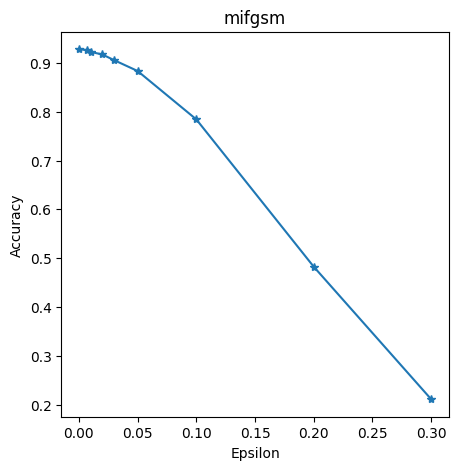

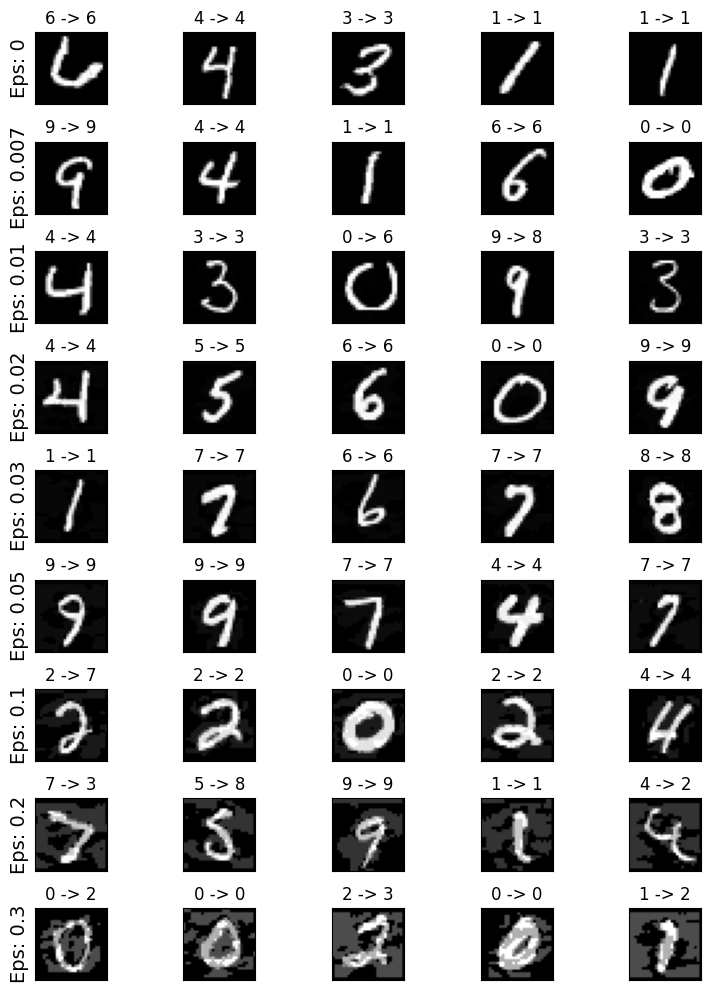

In [19]:
Temp=100
epochs=10
epsilons=[0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons)